# TERMINAL PRINCIPAL

## IMPORTES

In [3]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure
import os
import random
import io
import base64
import requests
from paddleocr import PaddleOCR
import easyocr
import cv2
from datetime import datetime
from pymongo import MongoClient
from PIL import Image 
from datetime import timedelta

## FUNCIONES PRINCIPALES

In [5]:
URI = f"mongodb://172.25.0.3:27017/"

### 1. Comprobar conectividad

In [6]:
def test_mongo_connection():

    try:
        
        uri = URI
        
        client = MongoClient(uri, serverSelectionTimeoutMS=5000)
        client.admin.command('ping')
        print("✅ Conexión exitosa a MongoDB")
        
    except ConnectionFailure as e:
        print(f"❌ Error de conexión a MongoDB: {str(e)}")
    except Exception as e:
        print(f"❌ Error: {str(e)}")

test_mongo_connection()

✅ Conexión exitosa a MongoDB


### 2. Un coche entra

#### 2.1 Funciones basicas

In [7]:
def seleccionar_foto_aleatoria(carpeta):

    archivos = [f for f in os.listdir(carpeta) if f.lower().endswith('.jpg')]
    if not archivos:
        raise FileNotFoundError("No se encontraron archivos .jpg en la carpeta especificada.")
    
    foto_aleatoria = random.choice(archivos)
    
    return os.path.join(carpeta, foto_aleatoria)

def image_to_base64(pil_image):
    buffered = io.BytesIO()
    pil_image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

PATH_COCHES = "../yolo/matriculas_recortadas"

#### 2.1 OCR Funciones


In [8]:
# --PREPROCESAMIENTO DE IMÁGENES--

def preprocess_image(image_path):
    """Limpia la imagen para mejorar el reconocimiento OCR"""
    # 1. Cargar imagen y convertir a escala de grises
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Ecualización de histograma CLAHE (mejora contraste)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # 3. Reducción de ruido (filtro bilateral)
    denoised = cv2.bilateralFilter(enhanced, 9, 75, 75)
    
    # 4. Binarización adaptativa
    thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    
    # 5. Operaciones morfológicas (cierre para unir caracteres rotos)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    return processed

#-- EASTOCR --

def easyocr_get_text_clean(image_path):
    """OCR con imagen preprocesada"""
    try:
        # Preprocesamiento
        clean_img = preprocess_image(image_path)
        
        # Convertir a formato compatible con EasyOCR (color BGR)
        img_bgr = cv2.cvtColor(clean_img, cv2.COLOR_GRAY2BGR)
        
        # Inicializar EasyOCR (optimizado para matrículas)
        reader = easyocr.Reader(['es'], gpu=False)  # Usar GPU si disponible
        
        # Configuración especial para matrículas
        result = reader.readtext(img_bgr, 
                            allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ',
                            paragraph=True,
                            slope_ths=0.1,
                            ycenter_ths=0.5)
        
        # Extraer el mejor resultado
        if result:
            # Ordenar por confianza y devolver el más alto
            best_result = max(result, key=lambda x: x[2])
            return best_result[1]
        
        return None
    
    except Exception as e:
        print(f"Error en OCR: {str(e)}")
        return None
    
#-- PADDLEOCR --

def paddleocr_get_text(image_path):
    ocr = PaddleOCR(use_angle_cls=True, lang='es')
    result = ocr.ocr(image_path, cls=True)
    if result and result[0]:
        return result[0][0][1][0]  # Extraer texto
    return None

#### 2.2 Local

In [ ]:
def process_car_entry_local():
    try:
        # PT1. Seleccionar foto aleatoria y cargarla como PIL Image
        photo_path = seleccionar_foto_aleatoria(PATH_COCHES)
        pil_image = Image.open(photo_path)
        print(f"Foto seleccionada: {photo_path}")

        # PT2. Simular detección de matrícula (usamos la misma imagen para el ejemplo)
        detect_plate_box = "detected_plate.jpg"
        print(f"Matrícula detectada: {detect_plate_box}")

        # PT3. Usar Tesseract para extraer texto de la matrícula
        license_plate_text = paddleocr_get_text(photo_path)
        if not license_plate_text:
            license_plate_text = "TEXTO_NO_DETECTADO"
        print(f"Texto de la matrícula (OCR): {license_plate_text}")

        # Conexión a MongoDB
        uri = URI
        client = MongoClient(uri)
        db = client['PIA']
        collection = db["coches"]

        # Convertir PIL Image a base64
        image_base64 = image_to_base64(pil_image)

        # Crear documento con la imagen en base64
        car_entry = {
            "photo_full": image_base64,
            "photo_plate": image_base64,
            "plate_text": license_plate_text,
            "status": "Dentro",
            "entry_timestamp": datetime.now(),
            "image_format": "JPEG",
            "encoding": "base64"
        }

        # Insertar en MongoDB
        collection.insert_one(car_entry)
        print("✅ Coche registrado en MongoDB con imagen en base64")

    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")

process_car_entry_local()

Foto seleccionada: ../yolo/matriculas_recortadas/5.jpg
Matrícula detectada: detected_plate.jpg
[2025/04/02 19:00:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/aluvesprada/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/aluvesprada/.paddleo

[2025/04/02 19:00:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.040557861328125
[2025/04/02 19:00:58] ppocr DEBUG: cls num  : 1, elapsed : 0.01596355438232422
[2025/04/02 19:00:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0795433521270752
Texto de la matrícula (OCR): 1969 KKW
✅ Coche registrado en MongoDB con imagen en base64


#### 2.3 Flask

In [ ]:
def process_car_entry_remote():
    PATH_COCHES = "../yolo/matriculas_recortadas"
    photo_path = seleccionar_foto_aleatoria(PATH_COCHES)
    pil_image = Image.open(photo_path)
    print(f"Foto seleccionada: {photo_path}")
    image_base64 = image_to_base64(pil_image)
    response = requests.post("http://127.0.0.1:8085/model_v2", json={"image": image_base64, "status": 0})

    if response.status_code == 200:
        print("✅ Coche enviado correctamente al servidor Flask")
    else:
        print(f"❌ Error: {response.text}")

### 3. Un coche con matricula [X] sale

#### 3.1 Local

In [9]:
def process_car_exit(plate_text):

    try:

        uri = URI
        client = MongoClient(uri)
        db = client['PIA']
        collection = db["coches"]

        car = collection.find_one({"plate_text": plate_text})
        
        if car:
            collection.update_one(
                {"_id": car["_id"]},
                {"$set": {"status": 2, "exit_timestamp": datetime.now()}}
            )
            print(f"✅ Coche con matrícula {plate_text} marcado como 'Fuera'")
            return car["entry_timestamp"]
        else:
            print(f"❌ No se encontró un coche con matrícula {plate_text} y estado 'Dentro'")
            return None
    
    except Exception as e:
        print(f"❌ Error al procesar la salida del coche: {str(e)}")
        return None

In [12]:
matricula = input("Introduce la matricula del coche que sale: ")
tiempo_entrada = process_car_exit(matricula)

if tiempo_entrada:
    tiempo_total = datetime.now() - tiempo_entrada
    if tiempo_total <= timedelta(minutes=15):
        print(f"✅ Todo bien. El coche con matrícula {matricula} ha estado dentro por {tiempo_total}.")
    else:
        print(f"❌ Tiempo excedido. El coche con matrícula {matricula} ha estado dentro por {tiempo_total}. MULTA DE 1000 BITCOINS.")


✅ Coche con matrícula 1969 KKW marcado como 'Fuera'
❌ Tiempo excedido. El coche con matrícula 1969 KKW ha estado dentro por 0:31:01.056934. MULTA DE 1000 BITCOINS.


In [163]:
def process_car_exit_remote(plate_text):
    response = requests.post("http://127.0.0.1:8085/model_v2", json={"matricula": plate_text, "status": 2})

    if response.status_code == 200:
        print("✅ Coche enviado correctamente al servidor Flask")
    else:
        print(f"❌ Error: {response.text}")

In [ ]:
matricula = input("Introduce la matricula del coche que sale: ")
process_car_exit_remote(matricula)

## DEBUG

🚗 Matrícula: 1969 KKW
🔄 Estado: 2
⏰ Fecha entrada: 2025-04-02 19:00:58.721000


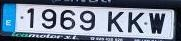

In [13]:
def display_last_car():
    """Muestra el último coche registrado"""
    try:
        # Conexión a MongoDB
        uri = URI
        client = MongoClient(uri)
        db = client['PIA']
        collection = db["coches"]
        
        # Obtener el último documento
        last_car = collection.find_one(sort=[('entry_timestamp', -1)])
        
        if not last_car:
            print("No hay coches registrados")
            return
        
        # Mostrar la información
        image_data = base64.b64decode(last_car['photo_full'])
        img = Image.open(io.BytesIO(image_data))
        
        print(f"🚗 Matrícula: {last_car['plate_text']}")
        print(f"🔄 Estado: {last_car['status']}")
        print(f"⏰ Fecha entrada: {last_car['entry_timestamp']}")
        
        display(img)
        
    except Exception as e:
        print(f"Error: {e}")

# Ejecutar
display_last_car()